In [81]:
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt
import numpy as np
import pandas as pd
import random as rm
import seaborn as sns
import pandas_profiling
fs = (14,7) ### размер графиков

In [82]:
dataset = pd.read_csv('Dataset_AB_TEST.csv', sep = ';').dropna()
dataset.describe(include = 'all')

,id_client,id_group,sum_pay,id_point,months_reg
count,1.084000e+04,10840,10840.000000,10840.000000,10840.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,test,NaN,NaN,NaN
freq,NaN,5669,NaN,NaN,NaN
mean,1.372953e+06,NaN,3568.758026,1180.039760,4.693911
std,1.482036e+04,NaN,2927.273978,4.353995,3.174513
min,1.359000e+06,NaN,59.000000,1178.000000,0.000000
25%,1.361710e+06,NaN,1250.750000,1178.000000,2.000000
50%,1.370636e+06,NaN,3173.500000,1179.000000,4.000000
75%,1.373417e+06,NaN,5356.500000,1179.000000,6.000000


In [83]:
dataset_raw = dataset.copy()

In [84]:
mask = {'test':2000,'control':1000}
dataset['cost_group'] = dataset['id_group'].map(mask)
dataset.head(2)

,id_client,id_group,sum_pay,id_point,months_reg,cost_group
0,1420218,test,3288.0,1199.0,8,2000
1,1390221,control,1267.0,1182.0,11,1000


In [85]:
dataset = dataset.loc[dataset['sum_pay'] >= 100] # убираем все строки, сумма покупки в которой строго меньше 100. 

<AxesSubplot:>

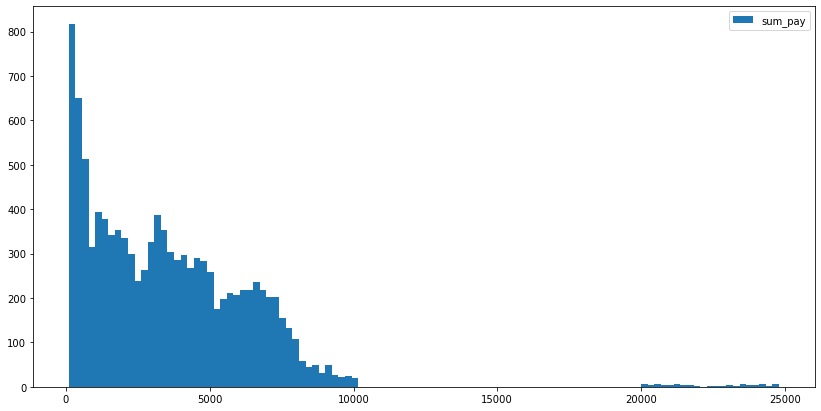

In [86]:
dataset.sum_pay.hist(figsize=fs, bins=len(dataset.sum_pay)//100, legend=True, grid=False)

In [87]:
dataset = dataset.loc[dataset['sum_pay'] < 15_000] # убираем все строки, сумма покупки в которой больше 15_000. 

In [88]:
dataset.groupby(['id_point', 'id_group']).agg({'months_reg' : ['count', 'min', 'max', 'mean'], 'sum_pay' : ['sum', 'min', 'max', 'mean']})

months_reg                      sum_pay                   \
                       count min max      mean        sum     min      max   
id_point id_group                                                            
1178.0   control        2403   0  14  4.407407  7296024.0   101.0   7499.0   
         test           2399   0  14  4.325552  7064444.0   100.0   7897.0   
1179.0   control        1697   0  14  4.659988  5653234.0   101.0   8228.0   
         test           1745   0  14  4.587393  5971088.0   101.0   8228.0   
1182.0   control        1012   0  14  5.166996  4085386.0   104.0   9362.0   
         test            950   0  14  5.760000  4697873.0   923.0  10141.0   
1186.0   control          23   0  13  6.391304   104558.0   326.0   7947.0   
         test             40   0  12  4.775000   145536.0   102.0   7751.0   
1188.0   control           5   1  12  6.400000    26010.0   112.0   7677.0   
         test              4   5   8  6.500000    19784.0  3233.0   6666.0   
1199.0   test            476   0  14  5.021008  1860618.0   763.0   7118.0   

                                
                          mean  
id_point id_group               
1178.0   control   3036.214732  
         test      2944.745311  
1179.0   control   3331.310548  
         test      3421.826934  
1182.0   control   4036.942688  
         test      4945.129474  
1186.0   control   4546.000000  
         test      3638.400000  
1188.0   control   5202.000000  
         test      4946.000000  
1199.0   test      3908.861345

In [89]:
true_points = [1178, 1179, 1182]

In [90]:
dataset[dataset['id_point'].isin(true_points)].groupby(['id_point', 'id_group']).agg({'months_reg' : ['count', 'min', 'max', 'mean'], 'sum_pay' : ['sum', 'min', 'max', 'mean']})

months_reg                      sum_pay                  \
                       count min max      mean        sum    min      max   
id_point id_group                                                           
1178.0   control        2403   0  14  4.407407  7296024.0  101.0   7499.0   
         test           2399   0  14  4.325552  7064444.0  100.0   7897.0   
1179.0   control        1697   0  14  4.659988  5653234.0  101.0   8228.0   
         test           1745   0  14  4.587393  5971088.0  101.0   8228.0   
1182.0   control        1012   0  14  5.166996  4085386.0  104.0   9362.0   
         test            950   0  14  5.760000  4697873.0  923.0  10141.0   

                                
                          mean  
id_point id_group               
1178.0   control   3036.214732  
         test      2944.745311  
1179.0   control   3331.310548  
         test      3421.826934  
1182.0   control   4036.942688  
         test      4945.129474

In [91]:
dataset = dataset[dataset['id_point'].isin(true_points)]

In [92]:
dataset_control = list(dataset.loc[dataset['id_group'] == 'control']['sum_pay'])
dataset_test = list(dataset.loc[dataset['id_group'] == 'test']['sum_pay'])

In [93]:
# dataset.profile_report()

# Часть 1. Создание статистических функций

### Задача 1

Постройте в Python функцию **statistical_analysis**, которая будет проводить анализ выборки.

In [94]:
iq = [0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]

iq_names = ['1ый дециль (10%) ........ >>>',
            '1ый квартиль (25%) ...... >>>',
            '3ий дециль (30%) ........ >>>',
            '4ый дециль (40%) ........ >>>',
            'Медиана (50%) ........... >>>',
            '6ой дециль (60%) ........ >>>',
            '3ий квартиль (75%) ...... >>>',
            '9ый дециль (90%) ........ >>>']

st_names = ['Среднее значение ........ >>>',
            'Дисперсия ............... >>>',
            'Стандартное отклонение .. >>>']

dct = dict()
dct['types'] = [list, tuple]
dct['length'] = 4
dct['numeric'] = [int, float]

In [95]:
def statistical_analysis(r, q=iq):
    
    if type(r) not in dct['types']:
        return print("Нужен список или кортеж!")
    if len(r) <= dct['length']:
        return print("Требуется более длинный ряд!")
    for each in range(len(r)):
        if type(r[each]) not in dct['numeric']:
            return print('Ты должен был бороться со злом, а не примкнуть к нему!')
    
    r = pd.Series(r)
    rmean = r.mean()
    print(f'{st_names[0]} {round(rmean,4)}')
    rvar = r.var()
    print(f'{st_names[1]} {round(rvar,4)}')
    rstd = r.std()
    print(f'{st_names[2]} {round(rstd,4)}')
    qs = np.quantile(r, q)
    print()
    
    for i in range(8):
        print(f'{iq_names[i]} {round(qs[i],4)}')
    
    plt.figure(figsize=fs)
    plt.title(f'<<< ГИСТОГРАММА >>>\n')
    sns.histplot(x = r, 
                 bins = 8, 
                 shrink=.85,
                 binrange=[0, round(r.max(), -len(str(int(r.max())))+1)])
    plt.show()
    return {'avg.' : rmean, 'var.' : rvar, 'std.' : rstd, 'Q.' : list(qs)}

### Задача 2

Постройте в Python функцию ***test_calc***, которая будет проводить t-тест на равенство средних двух выборок.

In [96]:
def test_calc(r1, r2, alpha = 0.05):

    s, p = st.ttest_ind(r1, r2)

    print('|----------- РЕЗУЛЬТАТЫ Т-ТЕСТА -----------|')
    
    if p < alpha:
        print(f'|>>> Распределения не равны                |\n|>>> p_value {p:9.6f} меньше alpha {alpha}   |')
    else:
        print(f'|>>> Распределения равны                   |\n|>>> p_value {p:9.6f} больше alpha {alpha}   |')
    
    print(f'|>>> mean r1 {pd.Series(r1).mean():12.6f}                  |')
    print(f'|>>> mean r2 {pd.Series(r2).mean():12.6f}                  |')
    print(f'|>>> mean dif r2-r1 {pd.Series(r2).mean()-pd.Series(r1).mean():12.6f}           |')
    print('|------------------------------------------|')

    return s, p

### Задача 3

Постройте в Python функцию **mann_whitney_func**, которая будет проводить тест Манна-Уитни для двух выборок.

In [97]:
def mann_whitney_func(r1, r2, alpha = 0.05):
    
    s, p = st.mannwhitneyu(r1, r2)
    
    print('|------ РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ ------|')  
    
    if p < alpha:
        print(f'|>>> Распределения не равны                |\n|>>> p_value {p:9.6f} меньше alpha {alpha}   |')
    else:
        print(f'|>>> Распределения равны                   |\n|>>> p_value {p:9.6f} больше alpha {alpha}   |')

    print('|------------------------------------------|')

    return s, p

# Часть 2. Расчет A/B теста

### Задача 1

**Общий анализ A/B Теста**

In [98]:
def show_hist(r1, r2, graph_title = '', xlabel = 'Размер платежа', ylabel = 'Кол-во людей'):
    
    for r in r1, r2:
        if type(r) not in dct['types']:
            return print("Нужен список или кортеж!")
        if len(r) <= dct['length']:
            return print("Требуется более длинный ряд!")  
        for each in range(len(r)):
            if type(r[each]) not in dct['numeric']:
                return print('Ты должен был бороться со злом, а не примкнуть к нему!')
    
    import re
    import traceback
    
    stack = traceback.extract_stack()
    arg_name = re.sub('show_hist\((.*)\)', '\g<1>', stack[-2][-1])
    arg_list = arg_name.split(',')
    
    plt.figure(figsize=fs)
    plt.title(graph_title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.histplot(r1, color='r', alpha=0.65, binwidth=200, binrange=[0,11000], label = arg_list[0].strip())
    sns.histplot(r2, color='g', alpha=0.35, binwidth=200, binrange=[0,11000], label = arg_list[1].strip())
    plt.axvline(pd.Series(r1).mean(), color='r', linestyle='--', linewidth=2, label = 'среднее '+arg_list[0].strip())
    plt.axvline(pd.Series(r2).mean(), color='g', linestyle='--', linewidth=2, label = 'среднее '+arg_list[1].strip())
    plt.legend()
    plt.show()

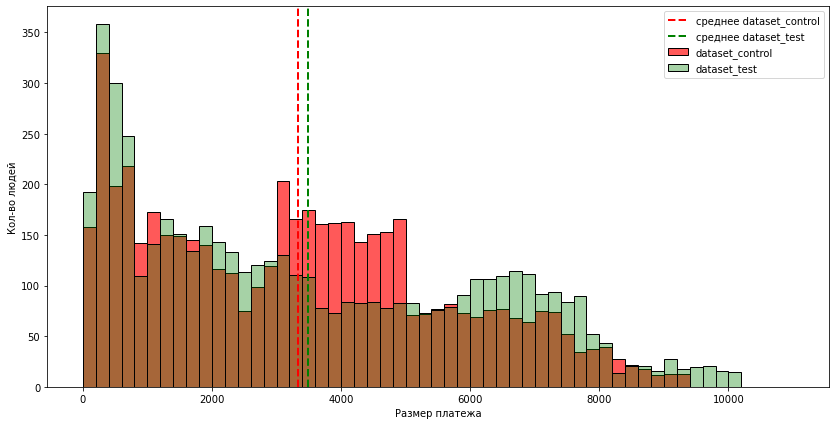

In [99]:
show_hist(dataset_control, dataset_test)

In [100]:
test_calc(dataset_control, dataset_test)

|----------- РЕЗУЛЬТАТЫ Т-ТЕСТА -----------|
|>>> Распределения не равны                |
|>>> p_value  0.002373 меньше alpha 0.05   |
|>>> mean r1  3332.285603                  |
|>>> mean r2  3481.233804                  |
|>>> mean dif r2-r1   148.948202           |
|------------------------------------------|


(-3.0398657636101745, 0.0023728338366294857)

In [101]:
mann_whitney_func(dataset_control, dataset_test)

|------ РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ ------|
|>>> Распределения равны                   |
|>>> p_value  0.453824 больше alpha 0.05   |
|------------------------------------------|


(12908783.5, 0.4538241173731298)

### Задача 2

**Анализ по торговым точкам**

In [102]:
dataset.head(2)

,id_client,id_group,sum_pay,id_point,months_reg,cost_group
1,1390221,control,1267.0,1182.0,11,1000
2,1363404,control,4259.0,1178.0,2,1000


In [103]:
groups = list(dataset.id_group.sort_values().unique())
points = list(dataset.id_point.sort_values().unique())

In [104]:
points_dataset = dict()

for p_each in points:
    for g_each in groups:
        key = '_'.join([g_each, str(p_each)])
        value = list(dataset.loc[(dataset['id_point'] == p_each) & (dataset['id_group'] == g_each)]['sum_pay'])
        points_dataset[key] = value

In [105]:
keys = list(points_dataset.keys())
keys

['control_1178.0',
 'test_1178.0',
 'control_1179.0',
 'test_1179.0',
 'control_1182.0',
 'test_1182.0']

*****************************************************************************************************************************
Для торговой точки №1178


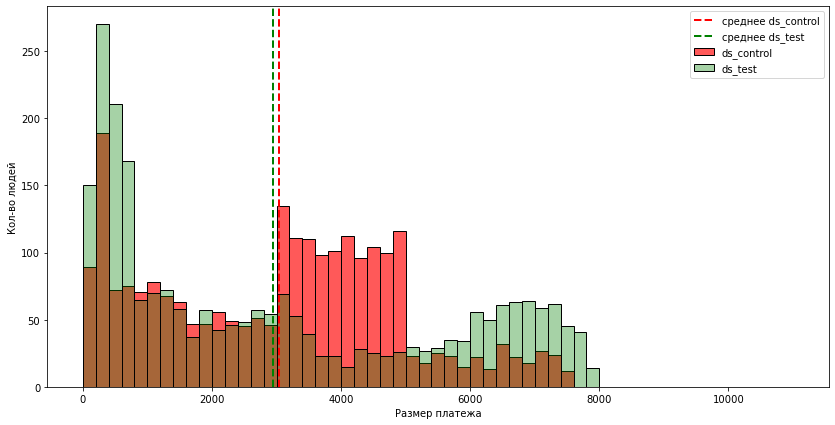

|----------- РЕЗУЛЬТАТЫ Т-ТЕСТА -----------|
|>>> Распределения равны                   |
|>>> p_value  0.160065 больше alpha 0.05   |
|>>> mean r1  3036.214732                  |
|>>> mean r2  2944.745311                  |
|>>> mean dif r2-r1   -91.469421           |
|------------------------------------------|
|------ РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ ------|
|>>> Распределения не равны                |
|>>> p_value  0.000003 меньше alpha 0.05   |
|------------------------------------------|


*****************************************************************************************************************************
Для торговой точки №1179


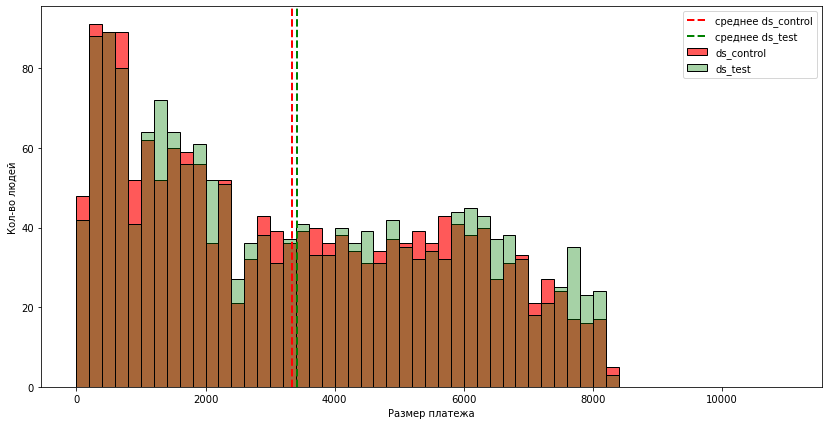

|----------- РЕЗУЛЬТАТЫ Т-ТЕСТА -----------|
|>>> Распределения равны                   |
|>>> p_value  0.261704 больше alpha 0.05   |
|>>> mean r1  3331.310548                  |
|>>> mean r2  3421.826934                  |
|>>> mean dif r2-r1    90.516386           |
|------------------------------------------|
|------ РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ ------|
|>>> Распределения равны                   |
|>>> p_value  0.258076 больше alpha 0.05   |
|------------------------------------------|


*****************************************************************************************************************************
Для торговой точки №1182


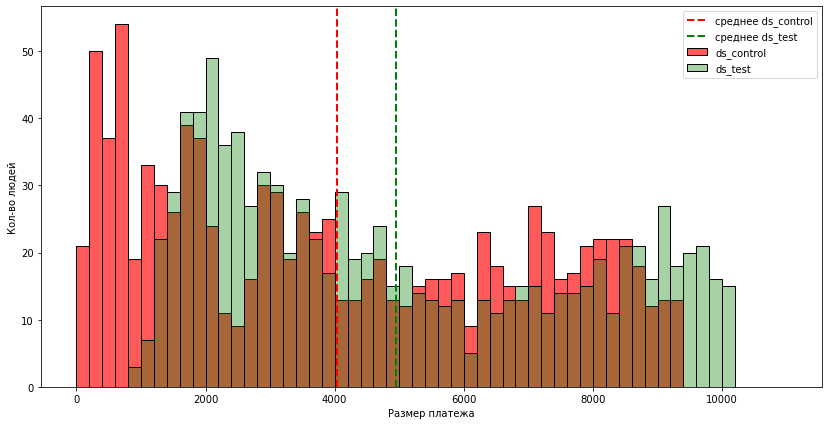

|----------- РЕЗУЛЬТАТЫ Т-ТЕСТА -----------|
|>>> Распределения не равны                |
|>>> p_value  0.000000 меньше alpha 0.05   |
|>>> mean r1  4036.942688                  |
|>>> mean r2  4945.129474                  |
|>>> mean dif r2-r1   908.186786           |
|------------------------------------------|
|------ РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ ------|
|>>> Распределения не равны                |
|>>> p_value  0.000000 меньше alpha 0.05   |
|------------------------------------------|




In [106]:
for i in range(0,len(keys),2):
    print(125*"*")
    print(f'Для торговой точки №{str(keys[i].split(".")[0]).split("_")[1]}')
    ds_control = points_dataset[keys[i:i+2][0]]
    ds_test = points_dataset[keys[i:i+2][1]]
    show_hist(ds_control,ds_test)
    test_calc(ds_control,ds_test)
    mann_whitney_func(ds_control,ds_test)
    print(f'\n')

# Часть 3. Сегментация и презентация

### Задача 1

**Сегментация по длительности регистрации**

#### Определяем необходимые функции:
****
<li> <b>tolist</b> -- создание листа со словарями для расчёта корреляций</li>
<li> <b>power</b> -- расчёт силы корреляции</li>
<li> <b>proxi_ranges</b> -- расчёт корреляции и печати результатов</li>

In [107]:
statdictP = dict()
statdictS = dict()
sd = list()
def tolist(x, y):
    '''x - data iterable array, 
    y - data iterable array'''
    ps, pv = st.pearsonr(x, y)
    pear = [ps, pv]
    ss, sv = st.spearmanr(x, y)
    spea = [ss, sv]
    statdictP['name'] = 'Пирсон'
    statdictP['data'] = pear
    statdictP['level'] = [0.3, 0.7]
    statdictP['alpha'] = 0.05
    statdictS['name'] = 'Спирман'
    statdictS['data'] = spea
    statdictS['level'] = [0.3, 0.7]
    statdictS['alpha'] = 0.05
    sd = [statdictP, statdictS]
    return sd

In [108]:
def power(lst):
    '''lst - list'''
    for i in range(len(lst)):
        if lst[i]['data'][1] < lst[i]['alpha']:
            nm = lst[i]['name']
            if abs(lst[i]['data'][0]) < lst[i]['level'][0]:
                pwr = 'слабая'
            elif abs(lst[i]['data'][0]) < lst[i]['level'][1]:
                pwr = 'средняя'
            else:
                pwr = 'сильная'
            print(f'Корреляция {nm}а: {pwr}')
        else:
            print(f'Корреляция {nm}а равна нулю')

In [109]:
def proxi_ranges(r1, r2, alpha = 0.05):
    '''r1 - data iterable array,
    r2 - data iterable array'''
    cov = np.cov(r1, r2)
    print('Ковариация: {:10.2f}'.format(cov[0][1]))
    print()
    print('Дисперсия для метрики 1: {:10.2f}'.format(cov[0][0]))
    print('Дисперсия для метрики 2: {:10.2f}'.format(cov[1][1]))
    print()
    power(tolist(r1, r2))

#### Готовим данные для анализа 

In [110]:
dataset.head(2)

,id_client,id_group,sum_pay,id_point,months_reg,cost_group
1,1390221,control,1267.0,1182.0,11,1000
2,1363404,control,4259.0,1178.0,2,1000


In [111]:
A = dataset['sum_pay']
B = dataset['months_reg']

In [112]:
proxi_ranges(A,B)

Ковариация:    4769.92

Дисперсия для метрики 1: 6130649.69
Дисперсия для метрики 2:      10.13

Корреляция Пирсона: средняя
Корреляция Спирмана: средняя


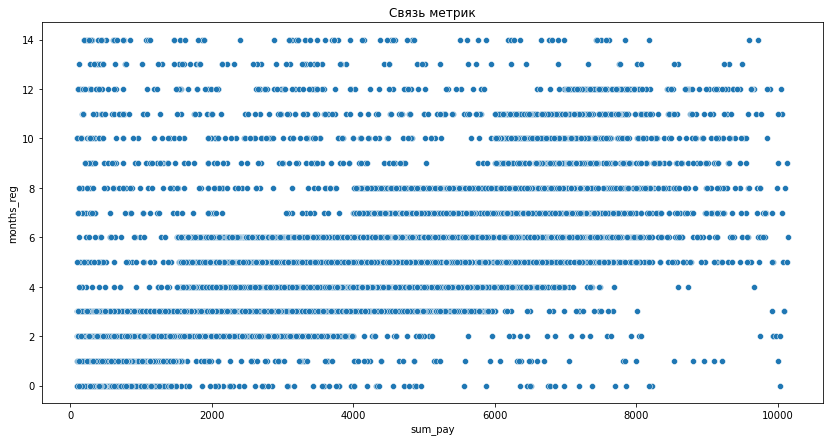

In [113]:
plt.figure(figsize=fs)
plt.title('Связь метрик')
sns.scatterplot(x = A,
                y = B)
plt.show()

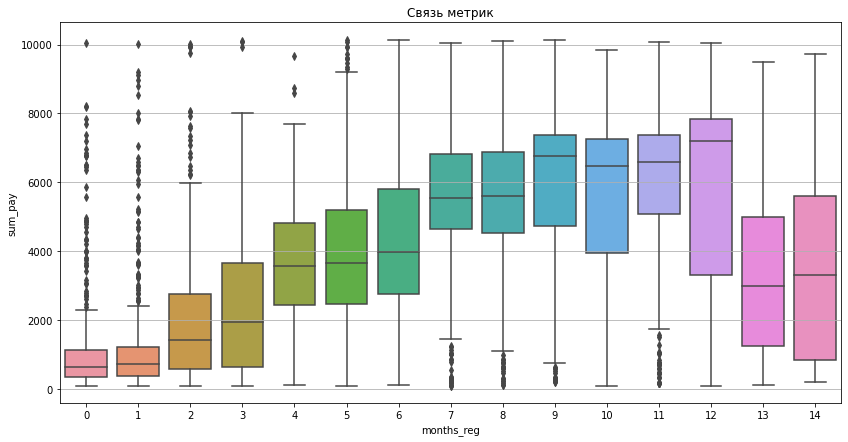

In [114]:
plt.figure(figsize=fs)
plt.title('Связь метрик')
sns.boxplot(x = B, y = A)
plt.grid(axis='y')
plt.show()

---

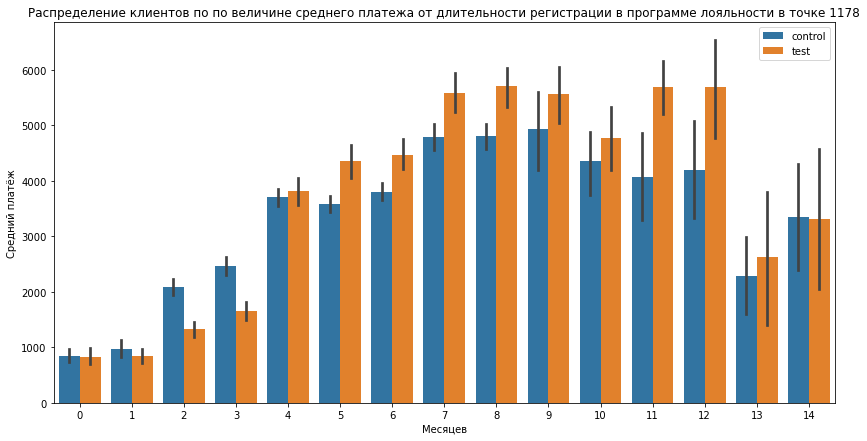

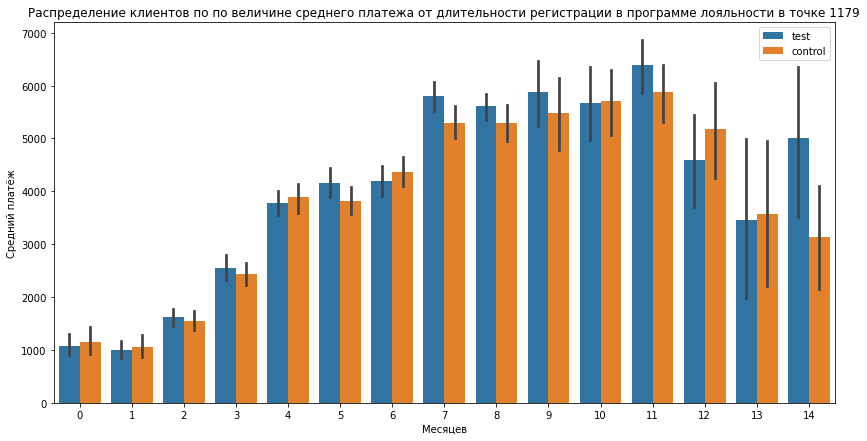

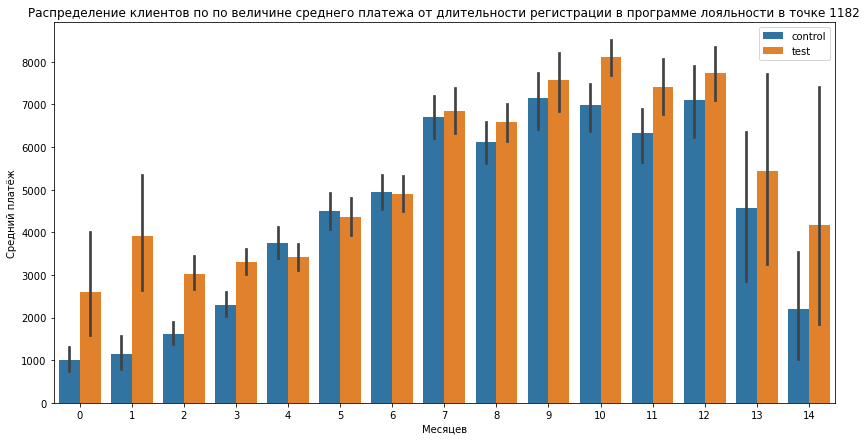

In [115]:
for each in points:

    temp = dataset[dataset['id_point'].isin([each])]
    
    fig = plt.figure(figsize=fs)
    sns.barplot(x = 'months_reg', y = 'sum_pay', hue = 'id_group' , data = temp)
    plt.title(f'Распределение клиентов по по величине среднего платежа от длительности регистрации в программе лояльности в точке {str(each).split(".")[0]}')
    plt.xlabel('Месяцев')
    plt.ylabel('Средний платёж')
    plt.legend()
    plt.show()

---